# Navigation

---

Resolution of the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). For the detailed implementation see `Report.pdf` file.

**Necessary packages:**
- [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md)
- [NumPy](http://www.numpy.org/).

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

### Start Enviroment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

try:
    env.close()
except:
    pass

env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe") # Change file_name if necessary
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Enviroment Details

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

# Project Resolution

The algorithms developed for this project are located in the following files:
- `memory.py`: Implementation of Replay Memory, SumTree, Prioritized Replay Memory.
- `nn.py`: Implementation of Q-Learning Neural Network.
- `agent.py`: Implementation of the Q-Learning Agent and training algorithm.

The `test.py` file was also created for test the Prioritized Memory implementation (located in memory.py file).

In [2]:
from agent import Agent
from test_sumtree import run_tests

### 1. Test Prioritezed Memory Implementation (This cell can be skipped)

In [3]:
run_tests()

test_SumTree (test_sumtree.TestSumTree) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.014s

OK
test_PriorityMemory (test_sumtree.TestPrioritizedMem) ... 


---- TEST SUM TREE --- 
Sum Tree
45 
28 17 
6 22 17 
1 5 9 13 17 
0(0) 1(1) 2(2) 3(3) 4(4) 5(5) 6(6) 7(7) 8(8) 9(9) 

Change probability of leaf idx [4]
65 
38 27 
6 32 27 
1 5 19 13 27 
0(0) 1(1) 2(2) 3(3) 4(14) 5(5) 6(6) 7(7) 8(8) 9(19) 

Add two new leafs with memory full "(50),5" and "(80),8"
77 
50 27 
18 32 27 
13 5 19 13 27 
50(5) 80(8) 2(2) 3(3) 4(14) 5(5) 6(6) 7(7) 8(8) 9(19) 


ok

----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


### 2. Train Agent
#### Traininf Function

In [4]:
import time
import datetime
import pickle
from collections import deque
import torch

def dqn(agent_, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, 
        save=True, save_name='', stop=False, verbose=True):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes.
        max_t (int): maximum number of timesteps per episode.
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection.
        eps_end (float): minimum value of epsilon.
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon.
        save (bool): If true save checkpoint (model weights) and scores to file.
        save_name (string): filename sufix for checkpoint (model weights) and scores.
        stop (bool): If true stop training when objective is achived.
        verbose (bool): If true print training results every 100 steps.
    """
    agent_.beta_increment_per_sampling = (1 - agent_.beta)/400 #set beta increment factor. Only for agent wit PER.
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    max_score = 0                      # initialize agent max score   
    start_time = time.time()           # register start time

    ## Interate over each episode and train the agent
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset episode state
        state = env_info.vector_observations[0]            # get first state
        score = 0                                          # reset episode score
        for t in range(max_t):                             # interate with the eviroment for a maximum of max_t timesteps
            action = agent_.act(state, eps)                # get action from agent based on actual state
            env_info = env.step(action.astype(int))[brain_name]  # take the selected action
            
            next_state = env_info.vector_observations[0]   # get the state obtained after taking action 
            reward = env_info.rewards[0]                   # get the reward obtained after taking action 
            done = env_info.local_done[0]                  # check for episode end
            
            agent_.step(state, action, reward, next_state, done)  # train the agent
            
            state = next_state                             # set state to the actual state
            score += reward                                # sum the reward to the episode scores
            if done:
                break                                     
        scores_window.append(score)                        # save most recent score
        scores.append(score)                               # save most recent score
        eps = max(eps_end, eps_decay*eps)                  # decrease epsilon
        
        ## Print training results
        exec_time = time.time() - start_time
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f} ' + \
              f'eps: {eps:.2f} beta: {agent_.beta:.4f} exec.time: {str(datetime.timedelta(seconds=exec_time))}', end="")
        if i_episode % 100 == 0 and verbose:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f} ' + \
                  f'eps: {eps:.2f} beta: {agent_.beta:.4f} exec.time: {str(datetime.timedelta(seconds=exec_time))}')
        
        ## Check if eviroment is solved and save checkpoint
        if np.mean(scores_window)>=13:
            if max_score == 0:
                print(' <-- Objective Achived!')
                print(f'- Average score of +{np.mean(scores_window)} over 100 consecutive episodes')
                
                if stop:
                    print('- Trainining Finished -')
                    exec_time = time.time() - start_time  
                    print(f'- Total training time:\t{str(datetime.timedelta(seconds=exec_time))}')
                    return scores, i_episode
                
            if np.mean(scores_window) >= max_score:
                max_score = np.mean(scores_window)
                
                if save:
                    torch.save(agent_.qnetwork_local.state_dict(), f'checkpoint_{save_name}.pth')

    exec_time = time.time() - start_time                   # compute training time
    
    ## save training scores
    if save:
        with open(f'scores_{save_name}.pkl', 'wb') as handle:
            pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
    print('- Trainining Finished -')
    print(f'\t-Total training time:\t{str(datetime.timedelta(seconds=exec_time))}')
    if max_score > 0:
        print(f'\t-Maximum average score of +{max_score} over 100 consecutive episodes')
    else:
        if stop:
            return scores, 9999
        print('!!! Objective NOT achived !!!')
    return scores

#### Auxiliar Plot Functontions

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
# plot the scores

def plot_scores(scores, rolling_window=100, title=''):
    """Plot Agent Traininig Scores per Episode.
    
    Params
    ======
        scores (list): Scores over each episode.
        rolling_window (int): Rolling mean window length.
        title (string): Chart title.
    """
    fig = plt.figure(dpi=127)
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    plt.title(title)
    return rolling_mean

def plot_pkl_score(save_name, rolling_window=100, title=''):
    """Plot Saved Scores.
    
    Params
    ======
        save_name (string): Scores file name sufix.
        rolling_window (int): Rolling mean window length.
        title (string): Chart title.
    """
    
    with open(f'scores_{save_name}.pkl', 'rb') as handle:
        scores = pickle.load(handle)
        
        plot_scores(scores, rolling_window, title)

#### Neural Network Grid Search Function

In [6]:
import itertools

def nn_gridsearch(hiper_dict,inter=1):
    """Grid Search for NN eural Network Hiperparameters.
    
    Find the best hiperparameter based on training speed (number of episodes taken to achive score of +13).
    
    Params
    ======
        hiper_dict (dict): Hiperparameters dictionary with key = <hiperparameter attribute name> and value = 
                            <list of hiperparameter values to be searched>. ex:
                            hiper_dict = {
                                            'start_filter': [16, 32],
                                            'layers': [1, 2],
                                            'dropout': [0.1, 0.2]
                                        } 
        inter (int): Number of intercations at each hiperparameter set.
                        
    """
    best_n_episode = 9999
    best = {}
    for hiper in itertools.product(*hiper_dict.values()):
        h_dict = {k: h for k, h in zip(hiper_dict.keys(), hiper)}
        
        for i in range(inter):
            

            agent = Agent(state_size=state_size, action_size=action_size, seed=420, 
                        DDQN=False, priority_mem=False, duel=False,
                        **h_dict)

            scores, lst_episode = dqn(agent, save=False, stop=True, verbose=False)

            if lst_episode < best_n_episode:
                best_n_episode = lst_episode
                best = h_dict

            print('-'*20)
    print(f'Best training speed: {best_n_episode}')
    print('Best Hiperprameters:')
    for k in best:
        print(f'\t{k}: {best[k]}')
        
    return best, best_n_episode


### 2.1. Select NN Best Hiperparameters (This cell can be skipped)
Given the large amount of time need for this step, only a few hiperparameters combinations were tested

In [7]:
hiper_dict = {
    'start_filter': [16,32,64],
    'layers': [1,2]
}

best, best_n_episode = nn_gridsearch(hiper_dict,3)

---------------
-- AGENT CREATED:
	Type: DQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 16
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 1543	Average Score: 13.03 eps: 0.01 beta: 0.4000 exec.time: 0:24:00.207019 <-- Objective Achived!
- Average score of +13.03 over 100 consecutive episodes
- Trainining Finished -
- Total training time:	0:24:00.207019
--------------------
---------------
-- AGENT CREATED:
	Type: DQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 16
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 1171	Average Score: 13.03 eps: 0.01 beta: 0.4000 exec.time: 0:17:58.709479 <-- Objective Achived!
- Average score of +13.03 over 100 consecutive episodes
- Trainining Finish

Episode 2000	Average Score: 11.68 eps: 0.01 beta: 0.4000 exec.time: 0:42:41.577738- Trainining Finished -
	-Total training time:	0:42:41.578738
--------------------
---------------
-- AGENT CREATED:
	Type: DQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 64
	Number of layers: 2
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 1584	Average Score: 13.02 eps: 0.01 beta: 0.4000 exec.time: 0:33:02.907910 <-- Objective Achived!
- Average score of +13.02 over 100 consecutive episodes
- Trainining Finished -
- Total training time:	0:33:02.909909
--------------------
Best training speed: 624
Best Hiperprameters:
	start_filter: 64
	layers: 1


In [8]:
best_old = best
best_n_episode_old = best_n_episode

hiper_dict = {
    'start_filter': [128,256],
    'layers': [1]
}

best, best_n_episode = nn_gridsearch(hiper_dict,3)

---------------
-- AGENT CREATED:
	Type: DQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 128
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 739	Average Score: 13.02 eps: 0.02 beta: 0.4000 exec.time: 0:14:29.805226 <-- Objective Achived!
- Average score of +13.02 over 100 consecutive episodes
- Trainining Finished -
- Total training time:	0:14:29.807224
--------------------
---------------
-- AGENT CREATED:
	Type: DQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 128
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 679	Average Score: 13.01 eps: 0.03 beta: 0.4000 exec.time: 0:13:46.270947 <-- Objective Achived!
- Average score of +13.01 over 100 consecutive episodes
- Trainining Finish

#### Best Hiperparameters

In [7]:
best_hiper = {'start_filter': 256, 'layers': 1}
# best_hiper = best

### 2.2 Train DQN Agent

States have length: 37
Number of actions: 4
---------------
-- AGENT CREATED:
	Type: DQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 256
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 100	Average Score: 0.68 eps: 0.61 beta: 0.4000 exec.time: 0:01:58.753359
Episode 200	Average Score: 4.03 eps: 0.37 beta: 0.4000 exec.time: 0:04:01.373902
Episode 300	Average Score: 7.94 eps: 0.22 beta: 0.4000 exec.time: 0:06:04.390336
Episode 400	Average Score: 10.06 eps: 0.13 beta: 0.4000 exec.time: 0:08:05.717333
Episode 500	Average Score: 11.75 eps: 0.08 beta: 0.4000 exec.time: 0:10:07.800333
Episode 589	Average Score: 13.04 eps: 0.05 beta: 0.4000 exec.time: 0:11:56.056334 <-- Objective Achived!
- Average score of +13.04 over 100 consecutive episodes
Episode 600	Average Score: 13.10 eps: 0.05 beta: 0.4000 exec.time: 0:12:09.526335
Episode 700	Averag

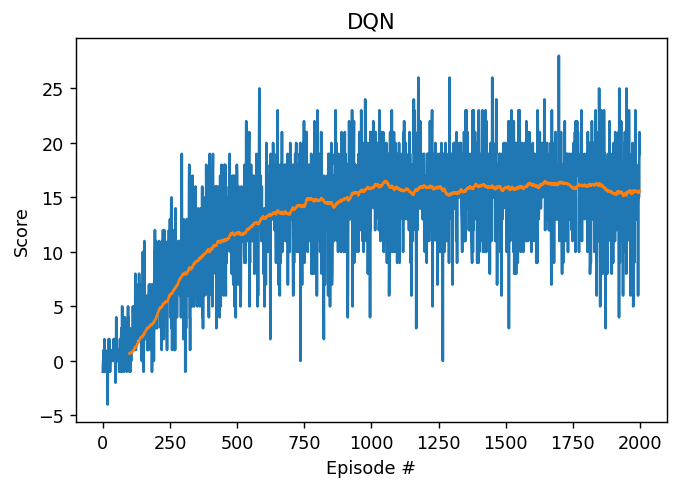

In [10]:
print('States have length:', state_size)
print('Number of actions:', action_size)
dqn_agent = Agent(state_size=state_size, action_size=action_size, seed=420, 
                  DDQN=False, priority_mem=False, duel=False,
                 **best_hiper)

LR = .0005
dqn_scores = dqn(dqn_agent, save_name='DQN')
_= plot_scores(dqn_scores,title='DQN')

States have length: 37
Number of actions: 4
---------------
-- AGENT CREATED:
	Type: DDQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 256
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 100	Average Score: 1.22 eps: 0.61 beta: 0.4000 exec.time: 0:02:23.818514
Episode 200	Average Score: 4.46 eps: 0.37 beta: 0.4000 exec.time: 0:04:48.428144
Episode 300	Average Score: 7.92 eps: 0.22 beta: 0.4000 exec.time: 0:07:15.724092
Episode 400	Average Score: 9.96 eps: 0.13 beta: 0.4000 exec.time: 0:09:39.9766046
Episode 500	Average Score: 10.63 eps: 0.08 beta: 0.4000 exec.time: 0:12:03.435039
Episode 600	Average Score: 12.54 eps: 0.05 beta: 0.4000 exec.time: 0:14:25.660521
Episode 697	Average Score: 13.02 eps: 0.03 beta: 0.4000 exec.time: 0:16:42.378524 <-- Objective Achived!
- Average score of +13.02 over 100 consecutive episodes
Episode 700	Avera

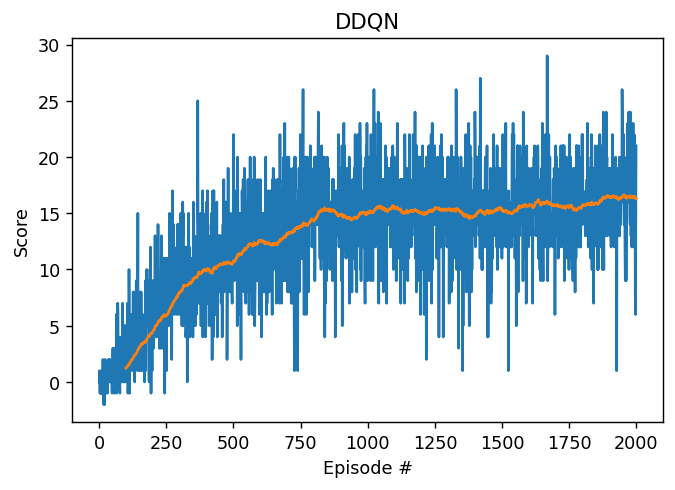

In [11]:
print('States have length:', state_size)
print('Number of actions:', action_size)
ddqn_agent = Agent(state_size=state_size, action_size=action_size, seed=420, 
                   DDQN=True, priority_mem=False, duel=False,
                  **best_hiper)

LR = .0005
ddqn_scores = dqn(ddqn_agent, save_name='DDQN')
_= plot_scores(ddqn_scores,title='DDQN')

States have length: 37
Number of actions: 4
---------------
-- AGENT CREATED:
	Type: PER DDQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 256
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 100	Average Score: 0.96 eps: 0.61 beta: 0.5500 exec.time: 0:02:44.237930
Episode 200	Average Score: 4.74 eps: 0.37 beta: 0.7000 exec.time: 0:05:29.031930
Episode 300	Average Score: 8.00 eps: 0.22 beta: 0.8500 exec.time: 0:08:13.576087
Episode 400	Average Score: 10.27 eps: 0.13 beta: 1.0000 exec.time: 0:10:57.985510
Episode 500	Average Score: 12.02 eps: 0.08 beta: 1.0000 exec.time: 0:13:42.767390
Episode 600	Average Score: 11.75 eps: 0.05 beta: 1.0000 exec.time: 0:16:26.510912
Episode 672	Average Score: 13.05 eps: 0.03 beta: 1.0000 exec.time: 0:18:27.871563 <-- Objective Achived!
- Average score of +13.05 over 100 consecutive episodes
Episode 700	A

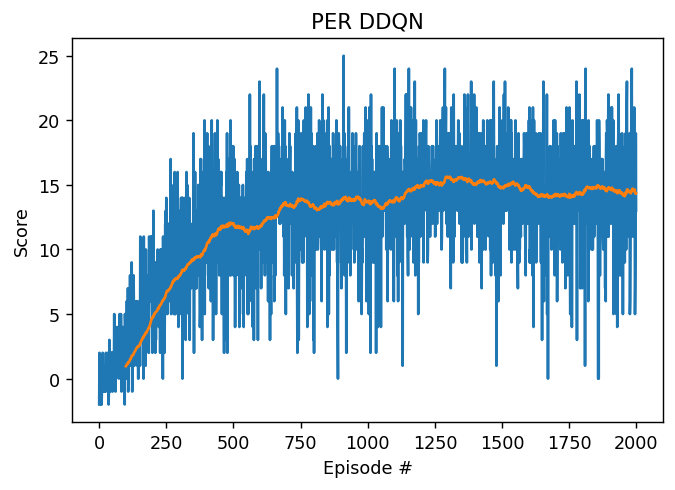

In [12]:
print('States have length:', state_size)
print('Number of actions:', action_size)
per_ddqn_agent = Agent(state_size=state_size, action_size=action_size, seed=420, 
                       DDQN=True, priority_mem=True, duel=False,
                      **best_hiper)

LR = .0001
per_ddqn_scores = dqn(per_ddqn_agent, save_name='PER_DDQN')
_= plot_scores(per_ddqn_scores,title='PER DDQN')

States have length: 37
Number of actions: 4
---------------
-- AGENT CREATED:
	Type: PER Dueling DDQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 256
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Episode 100	Average Score: 0.79 eps: 0.61 beta: 0.5500 exec.time: 0:02:54.004584
Episode 200	Average Score: 4.88 eps: 0.37 beta: 0.7000 exec.time: 0:05:55.649867
Episode 300	Average Score: 8.32 eps: 0.22 beta: 0.8500 exec.time: 0:08:55.667867
Episode 400	Average Score: 10.39 eps: 0.13 beta: 1.0000 exec.time: 0:11:57.423997
Episode 500	Average Score: 12.94 eps: 0.08 beta: 1.0000 exec.time: 0:14:57.245015
Episode 501	Average Score: 13.00 eps: 0.08 beta: 1.0000 exec.time: 0:14:59.169015 <-- Objective Achived!
- Average score of +13.0 over 100 consecutive episodes
Episode 600	Average Score: 13.20 eps: 0.05 beta: 1.0000 exec.time: 0:17:58.381015
Episod

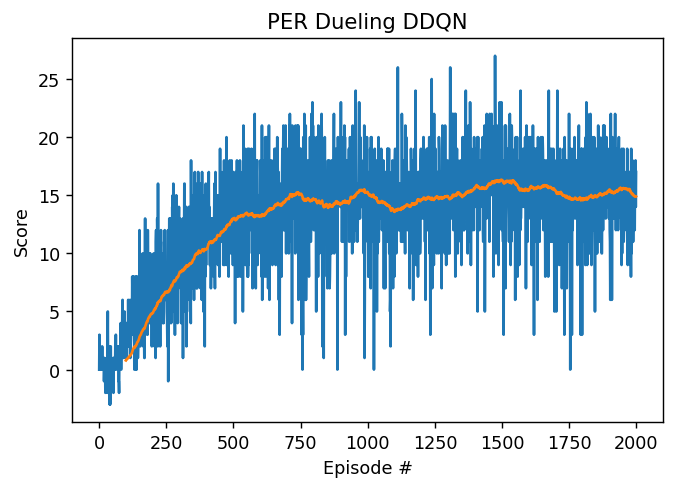

In [8]:
print('States have length:', state_size)
print('Number of actions:', action_size)
per_duel_ddqn_agent = Agent(state_size=state_size, action_size=action_size, seed=420, 
                            DDQN=True, priority_mem=True, duel=True,
                           **best_hiper)

LR = .0001
per_duel_ddqn_scores = dqn(per_duel_ddqn_agent, save_name='PER_Dueling_DDQN')
_= plot_scores(per_duel_ddqn_scores,title='PER Dueling DDQN')

# View Trained Agent in Action

In [15]:
agent = Agent(state_size=state_size, action_size=action_size, seed=420, 
                            DDQN=True, priority_mem=True, duel=True,
                           **best_hiper)

agent.qnetwork_local.load_state_dict(torch.load('checkpoint_PER_Dueling_DDQN.pth'))

for i in range(2):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0   
    for j in range(1000):
        action = agent.act(state,0.0)
        print(f'\rAction: {action} Turn {i} Score: {score}', end="")
        env_info = env.step(action.astype(int))[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward  
        state = next_state
        if done:
            break 
    print(f'Turn {i} Score: {score}')
            
# env.close()

---------------
-- AGENT CREATED:
	Type: PER Dueling DDQN
-- Hyperparameters:
  QNetwork:
	First layer filter size: 256
	Number of layers: 1
  Traininig:
	BUFFER SIZE: 100000
	BATCH SIZE: 64
	GAMMA: 0.99
	TAU (soft update target network): 0.001
	Learning Rate: 0.0005
	UPDATE EVERY: 4
---------------
Action: 0 Turn 0 Score: 20.0Turn 0 Score: 20.0
Action: 0 Turn 1 Score: 16.0Turn 1 Score: 16.0


# Best Performing Agent in Action (Per Duel DDQN)
![SegmentLocal](imgs/PER_DuelDDQN.gif "segment")